# Analysis of f$_{NL}$ with DESI LRGs

This notebook will include snippets regarding the fNL project with DESI Imaging.

In [1]:
!qstat -u medirz90


o0052.ten.osc.edu:
                                                                               Req'd  Req'd   Elap 
Job id               Username Queue    Name                 SessID NDS   TSK   Memory Time Use S Time 
-------------------- -------- -------- -------------------- ------ ----- ----- ------ ----- - -----
21013341             medirz90 serial   ondemand/sys/dashboa --         1     2     -- 01:00 C 01:00
21013466             medirz90 serial   ondemand/sys/dashboa --         1     2     -- 01:00 R 00:01


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import modules as md

In [4]:
%matplotlib inline

## Create C_ell for mocks with fNL != 0
Create cosmologies with fNL to test the pipeline

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

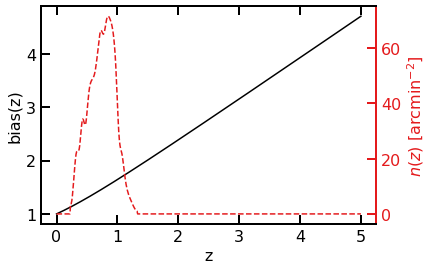

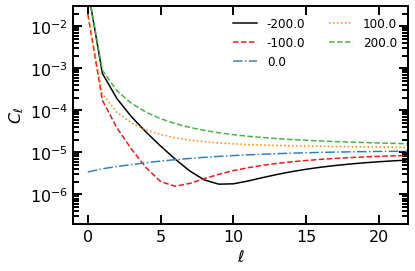

In [5]:
md.create_cl()

## Cleaned data
First we prepare the data into `hpix`, `features`, `label`, and `fracgood`.

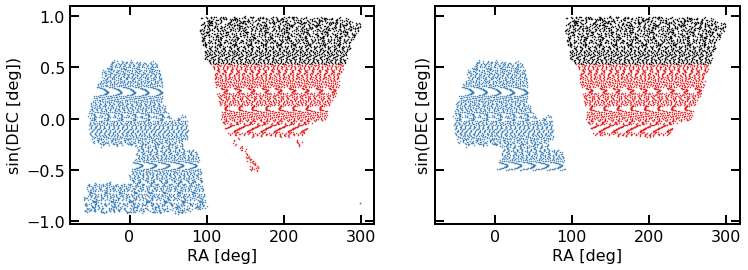

In [7]:
md.plot_radec()

## Target Density

798.8351667806639


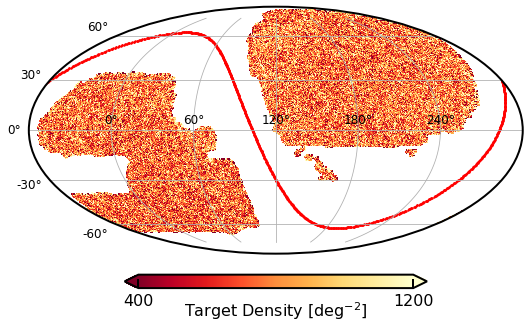

In [8]:
md.plot_ngal()

## Selection Functions

In [7]:
# everything
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecals_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecals_256_known1/nn-weights.fits']
md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desi_known1.hp256.fits')

wrote /fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desi_known1.hp256.fits


/tmp/slurmtmp.20925985/ipykernel_4234/674072037.py:66: RuntimeWarning: invalid value encountered in true_divide
  hpmap = hpmap / counts


In [6]:
# w dec cuts
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalsc_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalsc_256_known1/nn-weights.fits']

md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1.hp256.fits')

wrote /fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1.hp256.fits


/tmp/slurmtmp.20900451/ipykernel_10669/3419441414.py:10: RuntimeWarning: invalid value encountered in true_divide
  hpmap = hpmap / counts
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


In [6]:
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known2/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalsc_256_known2/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalsc_256_known2/nn-weights.fits']
#print(maps)
md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known2.hp256.fits')

wrote /fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known2.hp256.fits


/tmp/slurmtmp.20934454/ipykernel_30948/674072037.py:66: RuntimeWarning: invalid value encountered in true_divide
  hpmap = hpmap / counts
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
[762.85281187 882.96767244]
[768.70877619 872.53061009]
[765.42592846 876.23243794]
[760.62626899 884.85135114]


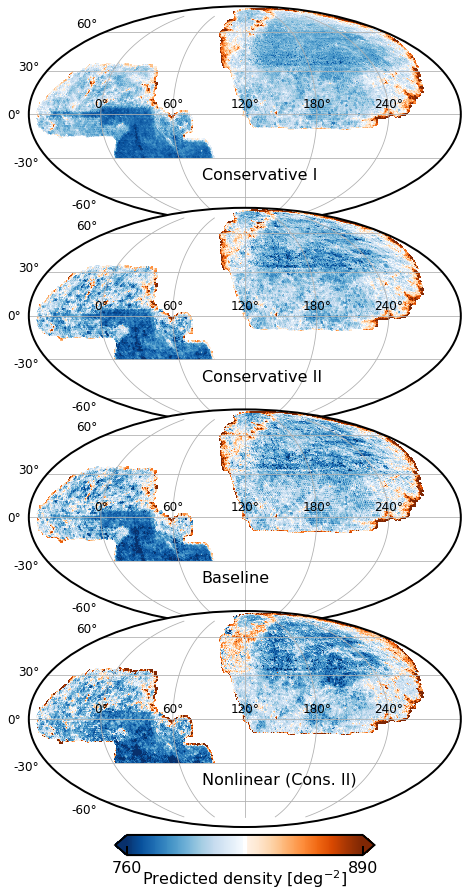

In [9]:
md.plot_npred()

Pearson Correlation Coefficient

100


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


bmzls done
100
ndecalsc done
100
sdecalsc done
(100, 9) 9
(100, 9) 9
(100, 9) 9


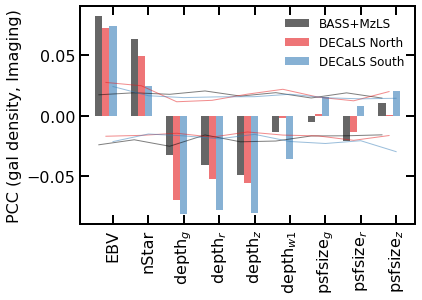

In [10]:
md.plot_pcc()

Pearson Correlation Coefficient

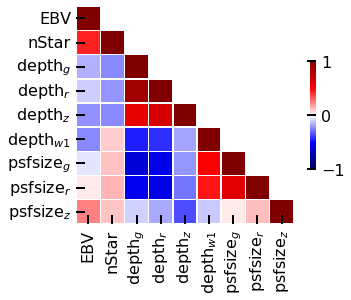

In [11]:
md.plot_corrmax()

## Cross Power

ell edges: [ 2  4  6  8 10 12 14 16 18 20]
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 81)
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 81)
nmocks: 1000, nbins: 81
nmocks: 1000, nbins: 81
Hartlap factor: 1.089422028353326
with nmocks: 1000 and nbins: 81
Hartlap factor: 1.089422028353326
with nmocks: 1000 and nbins: 81


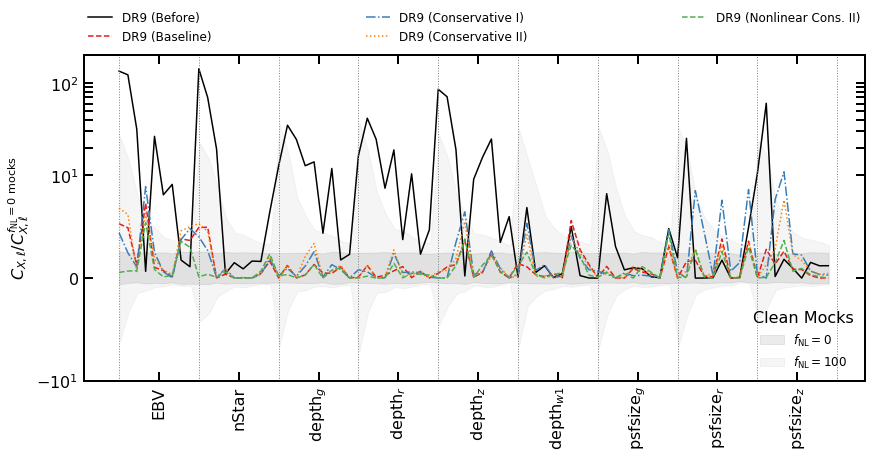

452.51439036526654 12.73599146545597
532.0629408864258 16.211484375059015


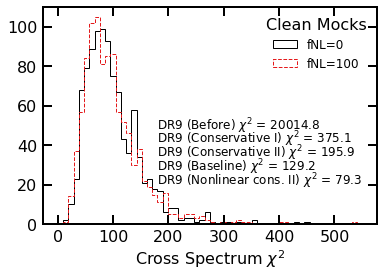

In [15]:
md.plot_clxtest()

## make histogram of mean density contrast

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

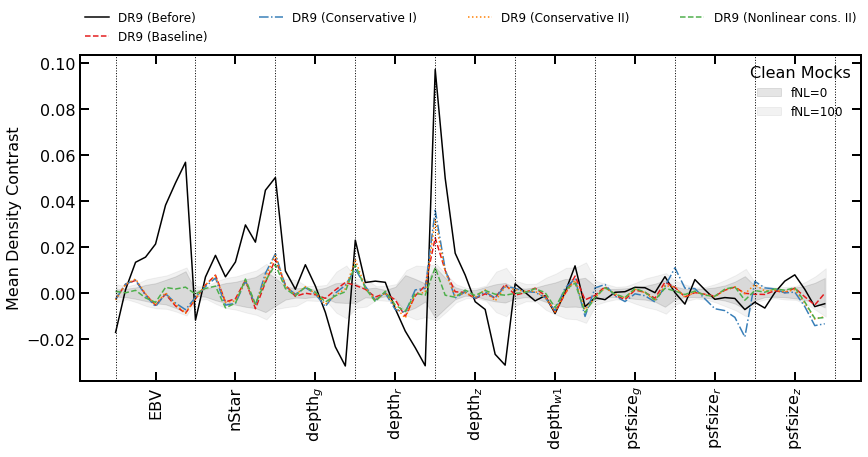

nmocks: 1000, nbins: 72
nmocks: 1000, nbins: 72
125.73479275585461 37.64838882795117
119.05340053084848 39.279522675915686


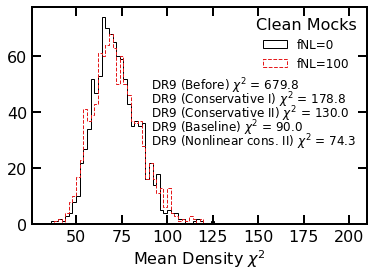

In [16]:
md.plot_nbartest()

## Bin C$_{\ell}$

In [18]:
for region in ['ndecals', 'sdecals', 'bmzls', 
               'ndecalsc', 'sdecalsc', 'desic']:
    md.bin_clmock('zero', region, '0', 'noweight', md.ut.ell_edges, log=True)
    if region == 'desic':
        md.bin_clmock('po100', region, '0', 'noweight', md.ut.ell_edges, log=True)   

[  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]
zero ndecals 0 noweight
1000 /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_311_lrg_zero_ndecals_256_noweight.npy
1000 768 37
going to do log transform
Hartlap with #mocks (1000) and #bins (37): 1.04
wrote /fs/ess/PHS0336/data/lognormal/v3/clustering/logclmock_0_lrg_zero_ndecals_256_noweight_mean.npz /fs/ess/PHS0336/data/lognormal/v3/clustering/logclmock_0_lrg_zero_ndecals_256_noweight_cov.npz
[  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]
zero sdecals 0 noweight
1000 /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_172_lrg_zero_sdecals_256_noweight.npy
1000 768 37
going to do log transform
Hartlap with #mocks (1000) and #bins (37): 1.04
wrote /fs/ess/PHS0336/data/lognormal/v3/clustering/logclmock_0_lrg_zero_sdeca

## Histogram of C$_{\ell}$ vs log(C$_{\ell}$)

bins [  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]


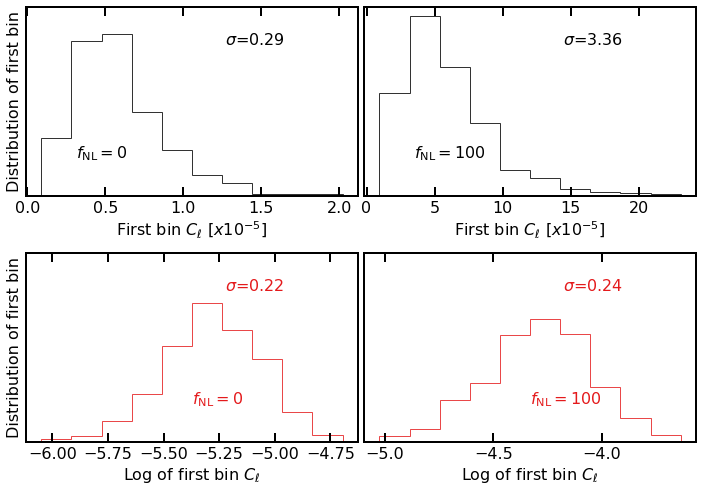

In [51]:
md.plot_clhist()

## MCMC Contours

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
log$C_{\ell}$                           & $100.97$& $100.97$& $100.33<\fnl<101.61$& $ 99.72<\fnl<102.23$\\
$C_{\ell}$                              & $100.97$& $100.95$& $100.32<\fnl<101.58$& $ 99.71<\fnl<102.18$\\
log$C_{\ell}$ using $f_{\rm NL}=0$ cov  & $101.01$& $101.03$& $100.42<\fnl<101.63$& $ 99.85<\fnl<102.21$\\
$C_{\ell}$ using $f_{\rm NL}=0$ cov     & $100.13$& $100.13$& $100.00<\fnl<100.26$& $ 99.88<\fnl<100.38$\\


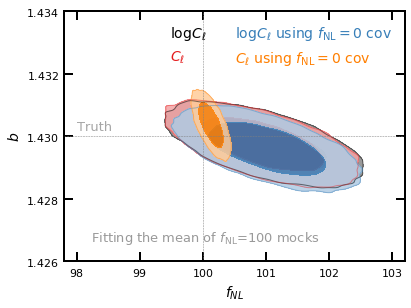

In [51]:
stats = md.plot_mcmc_mocks()

In [24]:
### Anything below needs to be reproduced

In [10]:
def plot_mcmc_mocks():
    stg = {'mult_bias_correction_order':0,'smooth_scale_2D':0.15, 
           'smooth_scale_1D':0.3, 'contours': [0.68, 0.95]}
    mc_kw = dict(names=['fnl', 'b', 'n0'], 
                 labels=['f_{NL}', 'b', '10^{7}n_{0}'], settings=stg) 
    read_kw = dict(ndim=3, iscale=[2])
    
    ze = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_zero_desic_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)
    nd = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_zero_ndecalsc_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)
    sd = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_zero_sdecalsc_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)
    bm = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc//mcmc_0_lrg_zero_bmzls_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)    
    po = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_po100_desic_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)    
    sc = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_scaled_desic_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)    
    stats = {}
    stats['0 [DESI]'] = ze.stats
    stats['0 [DECaLS North]'] = nd.stats
    stats['0 [DECaLS South]'] = sd.stats
    stats['0 [BASS+MzLS]'] = bm.stats    
    stats['100 [DESI]'] = po.stats    
    stats['100 [DESI] scaled cov'] = sc.stats        

    # Triangle plot
#     g = plots.get_single_plotter(width_inch=4*1.5)
#     g.settings.legend_fontsize = 14
#     g.plot_2d([po], 'fnl', 'b', filled=True)
#     g.add_x_marker(100)
#     g.add_y_marker(1.43)
#     g.get_axes().set_ylim(1.426, 1.434)
#     g.get_axes().set_xlim(100-2.2, 100+3.2)    
#     g.add_legend([r'$f_{\rm NL}=100$ [DESI]'], colored_text=True, legend_loc='lower left')    
#     g.fig.align_labels()

    
    g = plots.get_single_plotter(width_inch=4*1.5)
    g.settings.legend_fontsize = 14
    g.plot_2d([sc, po], 'fnl', 'b', filled=True)
    g.add_x_marker(100)
    g.add_y_marker(1.43)
    g.get_axes().set_ylim(1.426, 1.434)
    g.get_axes().set_xlim(100-2.2, 100+3.2)
    g.add_legend([r'w $f_{\rm NL}=0$ cov', 
                  r'$f_{\rm NL}=100$ [DESI]'], colored_text=True, legend_loc='lower left')    
    g.fig.align_labels()
    g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_po100.pdf', bbox_inches='tight')    
    
    g = plots.get_single_plotter(width_inch=4*1.5)
    g.settings.legend_fontsize = 14
    g.plot_2d([nd, sd, bm, ze], 'fnl', 'b', filled=True)
    g.add_x_marker(0)
    g.add_y_marker(1.43)
    g.get_axes().set_ylim(1.426, 1.434)
    g.get_axes().set_xlim(-2.2, 3.2)    
    g.add_legend(['DECaLS North', 'DECaLS South', 'BASS+MzLS', r'$f_{\rm NL}=0$ [DESI]'], 
                 colored_text=True, legend_loc='lower left')    
    g.fig.align_labels()
    g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_zero.pdf', bbox_inches='tight')    

    #pstats = pd.DataFrame(stats,
    #                  index=['MAP [scipy]', 'Mean [chain]', '16th', '84th', '2.5', '97.5']).T  
    for s, v in stats.items():
        print(f"{s:20s} & ${v[0]:6.2f}$ & ${v[1]:6.2f}$ & ${v[2]:6.2f} < \ fnl < {v[3]:6.2f}$ & ${v[4]:6.2f} < \ fnl < {v[5]:6.2f}$ ")    
    return stats            

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
0 [DESI]             & $  0.48$ & $  0.48$ & $  0.10 < \ fnl <   0.85$ & $ -0.28 < \ fnl <   1.22$ 
0 [DECaLS North]     & $  0.10$ & $  0.09$ & $ -0.60 < \ fnl <   0.77$ & $ -1.27 < \ fnl <   1.42$ 
0 [DECaLS South]     & $  0.69$ & $  0.68$ & $ -0.01 < \ fnl <   1.36$ & $ -0.70 < \ fnl <   2.02$ 
0 [BASS+MzLS]        & $  0.97$ & $  0.97$ & $  0.21 < \ fnl <   1.73$ & $ -0.55 < \ fnl <   2.45$ 
100 [DESI]           & $100.97$ & $100.95$ & $100.32 < \ fnl < 101.58$ & $ 99.71 < \ fnl < 102.18$ 
100 [DESI] scaled cov & $100.13$ & $100.13$ & $100.00 < \ fnl < 100.26$ & $ 99.88 < \ fnl < 100.38$ 


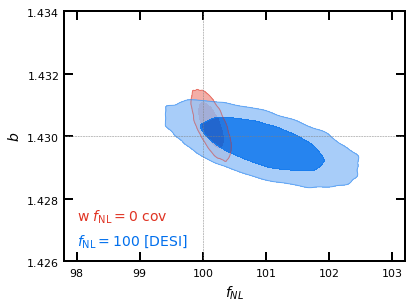

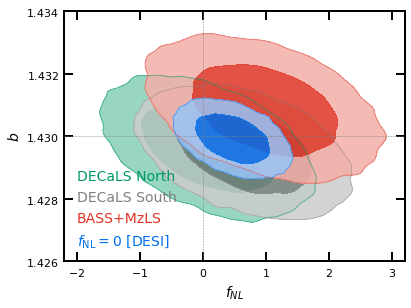

In [11]:
stats = plot_mcmc_mocks()

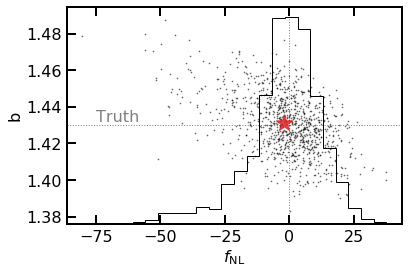

In [12]:
bf = np.load('/fs/ess/PHS0336/data/lognormal/v3/mcmc/bestfit_0_lrg_zero_desic_256_noweight.npz')

plt.scatter(*bf['params'][:, :2].T, s=2, marker='.', alpha=0.5, color='C0')
plt.scatter(*bf['params'].mean(axis=0)[:2],  s=300, marker='*', color='C1', alpha=0.8)
plt.axvline(0, lw=1, ls=':', color='grey', zorder=-10)
plt.axhline(1.43, lw=1, ls=':', color='grey', zorder=-10)
plt.text(-75, 1.432, 'Truth', color='grey')
plt.xlabel(r'$f_{\rm NL}$')
plt.ylabel('b')
plt.twinx()
plt.yticks([])
plt.hist(bf['params'][:, 0], zorder=-10, histtype='step', bins=24, color='C0')
plt.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/bestfit_zero.pdf', bbox_inches='tight')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


<Figure size 1296x972 with 0 Axes>

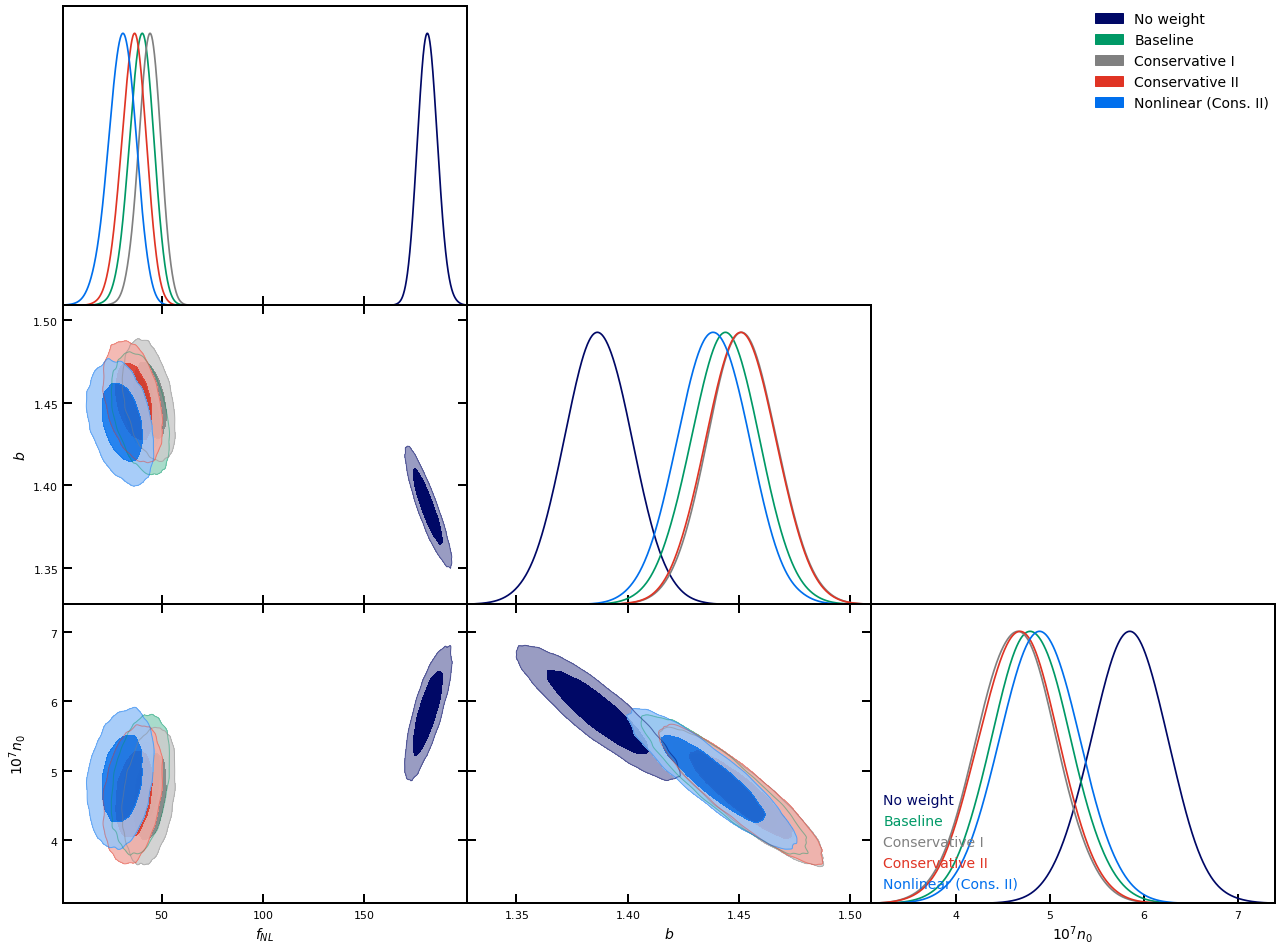

<Figure size 1296x972 with 0 Axes>

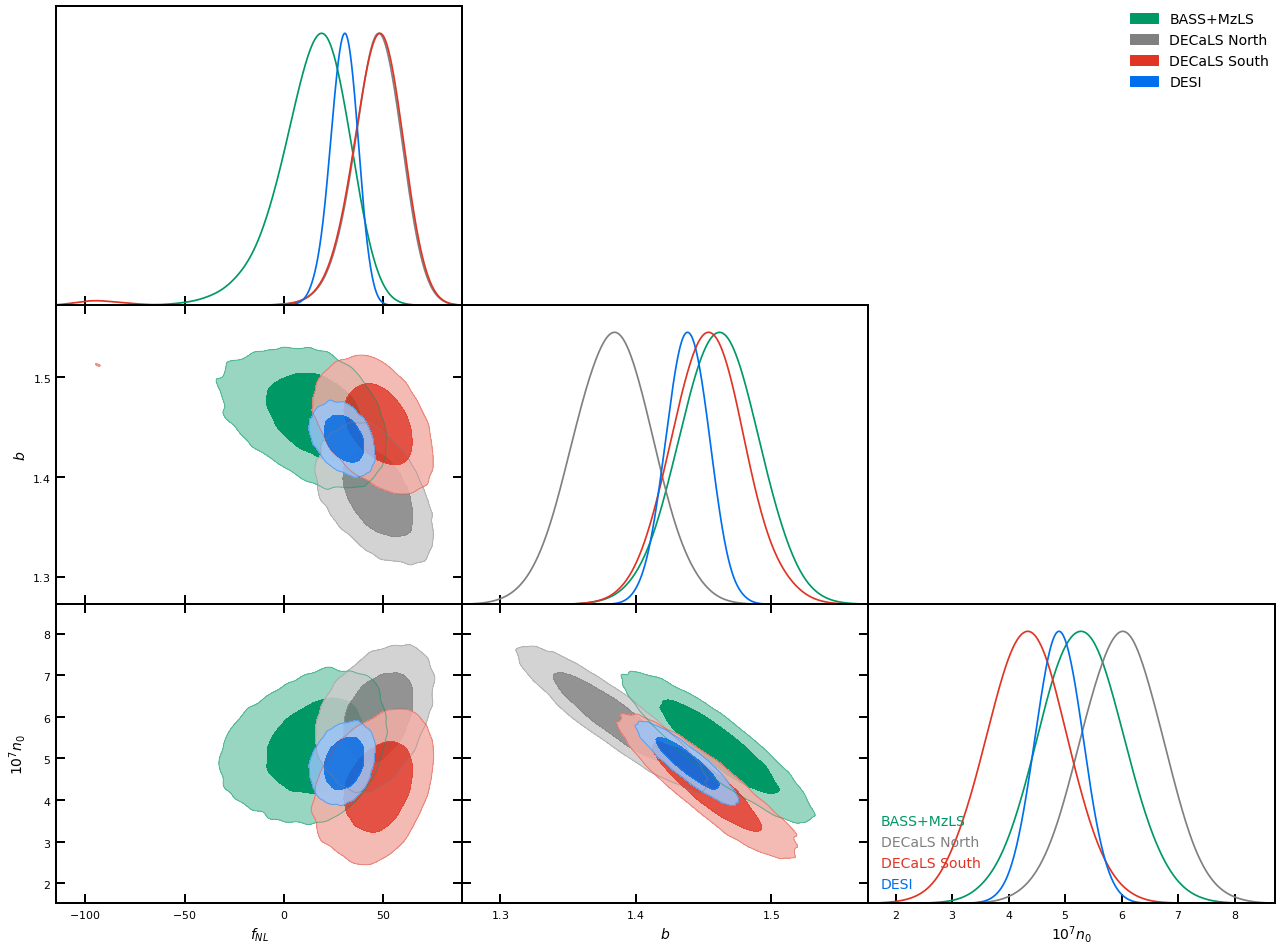

No Weight            & $181.64$ & $181.80$ & $177.05 < \ fnl < 186.53$ & $172.80 < \ fnl < 191.36$ 
Baseline             & $ 40.24$ & $ 39.68$ & $ 33.89 < \ fnl <  45.48$ & $ 27.77 < \ fnl <  50.66$ 
Conservative I       & $ 44.10$ & $ 43.75$ & $ 38.51 < \ fnl <  49.01$ & $ 32.96 < \ fnl <  53.87$ 
Conservative II      & $ 36.38$ & $ 35.87$ & $ 29.94 < \ fnl <  41.79$ & $ 23.71 < \ fnl <  47.14$ 
Nonlinear (Cons. II) & $ 31.07$ & $ 29.98$ & $ 23.39 < \ fnl <  36.60$ & $ 16.08 < \ fnl <  42.43$ 
Nonlinear (Cons. II) - BMZLS & $ 19.10$ & $ 14.27$ & $ -2.00 < \ fnl <  30.66$ & $-24.94 < \ fnl <  42.74$ 
Nonlinear (Cons. II) - NDEC & $ 48.02$ & $ 46.67$ & $ 35.24 < \ fnl <  58.30$ & $ 21.55 < \ fnl <  68.68$ 
Nonlinear (Cons. II) - SDEC & $ 48.58$ & $ 44.58$ & $ 35.43 < \ fnl <  57.55$ & $ 16.48 < \ fnl <  66.78$ 


{'No Weight': [181.6375785735537,
  181.7993757027124,
  177.05199700250202,
  186.53190973368598,
  172.80490299294868,
  191.3582440974566],
 'Baseline': [40.243320350296564,
  39.68120597615029,
  33.88559218211781,
  45.48227953642645,
  27.77004451549613,
  50.66029088554336],
 'Conservative I': [44.09720428537489,
  43.75119412164682,
  38.51044170837331,
  49.00957700177564,
  32.96055338705872,
  53.86715020922851],
 'Conservative II': [36.37606893250569,
  35.87096683300642,
  29.93791726982279,
  41.791230793321255,
  23.709607501105754,
  47.1425134790191],
 'Nonlinear (Cons. II)': [31.06581227976694,
  29.98140711202613,
  23.385204359827295,
  36.59564131899409,
  16.083313012987965,
  42.43456854533248],
 'Nonlinear (Cons. II) - BMZLS': [19.103121556095733,
  14.27161303548566,
  -2.000173804999103,
  30.664336575844366,
  -24.94371835300202,
  42.73747667550888],
 'Nonlinear (Cons. II) - NDEC': [48.02249922085959,
  46.666604394363254,
  35.23975548862311,
  58.298441565

In [22]:
def plot_mcmc_data():
    stg = {'mult_bias_correction_order':0,'smooth_scale_2D':0.15, 
           'smooth_scale_1D':0.3, 'contours': [0.68, 0.95]}
    mc_kw = dict(names=['fnl', 'b', 'n0'], 
                 labels=['f_{NL}', 'b', '10^{7}n_{0}'], settings=stg) 
    read_kw = dict(ndim=3, iscale=[2])
    
    ze = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)
    po = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_linp_all_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)    
    kn = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_linp_known_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)    
    kn1 = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_linp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)        
    knn1 = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
    knn1b = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_bmzls_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)                
    knn1n = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecalsc_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)                
    knn1s = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_sdecalsc_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)                    
    #knn2 = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desi_dnnp_known2_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
    stats = {}
    stats['No Weight'] = ze.stats
    stats['Baseline'] = po.stats    
    stats['Conservative I'] = kn.stats    
    stats['Conservative II'] = kn1.stats
    stats['Nonlinear (Cons. II)'] = knn1.stats    
    stats['Nonlinear (Cons. II) - BMZLS'] = knn1b.stats    
    stats['Nonlinear (Cons. II) - NDEC'] = knn1n.stats    
    stats['Nonlinear (Cons. II) - SDEC'] = knn1s.stats        
    #stats['Nonlinear (Depths+EBV)'] = knn2.stats    

    # Triangle plot
    g = plots.get_single_plotter(width_inch=3*4*1.5)
    g.settings.legend_fontsize = 14
    #g.plot_2d([ze, po, kn, kn1], 'fnl', 'b', filled=True)
    g.triangle_plot([ze, po, kn, kn1, knn1], filled=True, legend_labels=['No weight', 'Baseline',
                                                                        'Conservative I', 'Conservative II',
                                                                        'Nonlinear (Cons. II)'])
    g.add_legend(['No weight', 'Baseline', 'Conservative I', 'Conservative II', 'Nonlinear (Cons. II)'], 
                 colored_text=True, legend_loc='lower left', )    
    g.fig.align_labels()
    g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_dr9.pdf', bbox_inches='tight')    
    plt.show()
    
    
    # Triangle plot
    g = plots.get_single_plotter(width_inch=3*4*1.5)
    g.settings.legend_fontsize = 14
    #g.plot_2d([ze, po, kn, kn1], 'fnl', 'b', filled=True)
    g.triangle_plot([knn1b, knn1n, knn1s, knn1], filled=True, 
                    legend_labels=['BASS+MzLS', 'DECaLS North', 'DECaLS South', 'DESI'])
    g.add_legend(['BASS+MzLS', 'DECaLS North', 'DECaLS South', 'DESI'], 
                 colored_text=True, legend_loc='lower left', )    
    g.fig.align_labels()
    g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_dr9_2.pdf', bbox_inches='tight')    
    plt.show()
    
    for s, v in stats.items():
        print(f"{s:20s} & ${v[0]:6.2f}$ & ${v[1]:6.2f}$ & ${v[2]:6.2f} < \ fnl < {v[3]:6.2f}$ & ${v[4]:6.2f} < \ fnl < {v[5]:6.2f}$ ")    
        
    return stats 

plot_mcmc_data()

In [29]:
knn1 = np.load('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_dnnp_known1_steps10k_walkers50.npz')
bf = np.load('/fs/ess/PHS0336/data/lognormal/v3/mcmc/bestfit_0_lrg_zero_desic_256_noweight.npz')

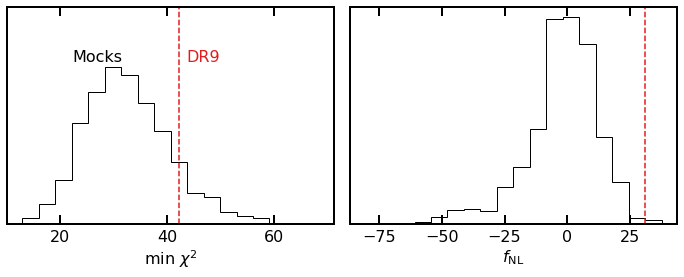

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.05)

ax[0].hist(2*bf['neglog']/1000., histtype='step', bins=18)
ax[0].axvline(2*knn1['best_fit_logprob'], ls='--', color='C1')

ax[1].hist(bf['params'][:, 0], histtype='step', bins=18)
ax[1].axvline(knn1['best_fit'][0], ls='--', color='C1')

ax[0].set(xlabel=r'min $\chi^{2}$', yticks=[])
ax[1].set(xlabel=r'$f_{\rm NL}$')

ax[0].text(0.2, 0.75, 'Mocks', transform=ax[0].transAxes)
ax[0].text(0.55, 0.75, 'DR9', color='C1', transform=ax[0].transAxes)

fig.align_xlabels() 
fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/pdf_dr9vsmocks.pdf', bbox_inches='tight')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


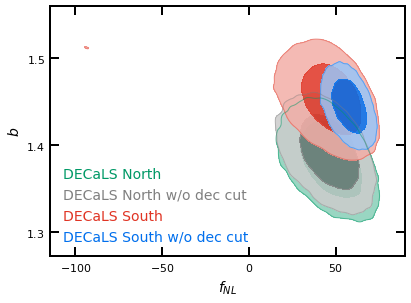

DECaLS North         & $ 48.02$ & $ 46.67$ & $ 35.24 < \ fnl <  58.30$ & $ 21.55 < \ fnl <  68.68$ 
DECaLS North w/o dec cut & $ 47.07$ & $ 45.46$ & $ 34.31 < \ fnl <  56.83$ & $ 20.85 < \ fnl <  66.56$ 
DECaLS South         & $ 48.58$ & $ 44.58$ & $ 35.43 < \ fnl <  57.55$ & $ 16.48 < \ fnl <  66.78$ 
DECaLS South w/o dec cut & $ 57.99$ & $ 57.55$ & $ 51.06 < \ fnl <  64.04$ & $ 44.24 < \ fnl <  70.02$ 


In [21]:
stg = {'mult_bias_correction_order':0,'smooth_scale_2D':0.15, 
       'smooth_scale_1D':0.3, 'contours': [0.68, 0.95]}
mc_kw = dict(names=['fnl', 'b', 'n0'], 
             labels=['f_{NL}', 'b', '10^{7}n_{0}'], settings=stg) 
read_kw = dict(ndim=3, iscale=[2])

nd = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
ndc = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecalsc_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
sd = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_sdecals_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
sdc = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_sdecalsc_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            


stats = {}
stats['DECaLS North'] = ndc.stats
stats['DECaLS North w/o dec cut'] = nd.stats
stats['DECaLS South'] = sdc.stats
stats['DECaLS South w/o dec cut'] = sd.stats


labels = stats.keys()

# Triangle plot
g = plots.get_single_plotter(width_inch=4*1.5)
g.settings.legend_fontsize = 14
g.plot_2d([ndc, nd, sdc, sd], 'fnl', 'b', filled=True, legend_labels=labels)
g.add_legend(labels, colored_text=True, legend_loc='lower left', )    
g.fig.align_labels()
g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_dr9_cutdec.pdf', bbox_inches='tight')
plt.show()

for s, v in stats.items():
    print(f"{s:20s} & ${v[0]:6.2f}$ & ${v[1]:6.2f}$ & ${v[2]:6.2f} < \ fnl < {v[3]:6.2f}$ & ${v[4]:6.2f} < \ fnl < {v[5]:6.2f}$ ")    

## Model vs Observations

In [8]:
def plot_model(fnltag='po100'):
    bm = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_{fnltag}_desic_256_noweight_steps10k_walkers50.npz')
    zbdndz = init_sample(kind='lrg')
    
    # read survey geometry
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desic_256.fits')
    w = np.zeros(12*256*256)
    w[dt['hpix']] = 1.0
    weight = hp.ud_grade(w, 1024)
    mask = weight > 0.5

    model = Spectrum()
    model.add_tracer(*zbdndz, p=1.0)
    model.add_kernels(np.arange(2000))


    wind = WindowSHT(weight, mask, np.arange(2048), ngauss=2048)
    fnl, b, noise = bm['best_fit']
    print(fnl, b)
    
    el_g = np.arange(2000)
    cl_bf = model(el_g, fnl=fnl, b=b, noise=noise)

    cl_bfw = wind.convolve(el_g, cl_bf)
    lmax = max(el_g)+1
    cl_bfwic = wind.apply_ic(cl_bfw[:lmax])

    cl_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_{fnltag}_desic_256_noweight_mean.npz')
    cl_cov_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_{fnltag}_desic_256_noweight_cov.npz')

    el_edges = cl_['el_edges']
    el = cl_['el_bin']
    cl = cl_['cl']
    cl_err = np.diagonal(cl_cov_['clcov'])**0.5

    cl_models = {}
    for name, cl_i in zip(['Best Fit Model', '+ Window Convolution', '+ Integral Constraint'],
                          [cl_bf, cl_bfw[:2000], cl_bfwic[:2000]]):

        cl_models[name] = ut.histogram_cell(el_g, cl_i, bins=el_edges)


    fig = plt.figure(figsize=(7, 7), constrained_layout=False)
    gs = GridSpec(3, 1, figure=fig)

    ax1 = fig.add_subplot(gs[:2, 0])
    ax2 = fig.add_subplot(gs[2, 0])

    f = 1.0e5
    lw = [0.8, 0.8, 3.]
    ls = ['-', '-', '-']
    al = [1., 1., 0.7]
    for i, (n, v) in enumerate(cl_models.items()):
        kw = dict(label=n, lw=lw[i], ls=ls[i], alpha=al[i])
        ax1.plot(v[0], f*v[1], **kw)
        ax2.plot(el, v[1]/cl, **kw)

    ax1.plot(el, f*cl, 'C0--', label='Mean of Mocks')
    ax2.axhline(1.0, color='C0', ls='--')
    ax2.fill_between(el, 1-cl_err/cl, 1+cl_err/cl, alpha=0.2)


    ax1.legend(ncol=1)
    ax1.set(xscale='log', ylabel=r'$10^{5}C_{\ell}$') #, yscale='log')
    ax1.tick_params(labelbottom=False)
    ax2.set(xscale='log', xlabel=r'$\ell$', ylabel='Ratio', xlim=ax1.get_xlim(), ylim=(0.975, 1.025))

    fig.subplots_adjust(hspace=0.0, wspace=0.02)
    fig.align_labels()

    fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/model_mock.pdf', bbox_inches='tight')     

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

0.4797038343830716 1.4299168308979995


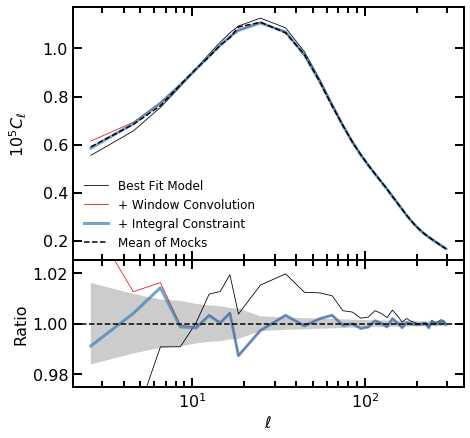

In [9]:
plot_model(fnltag='zero')

In [10]:
zbdndz = init_sample(kind='lrg')

# read survey geometry
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desic_256.fits')
w = np.zeros(12*256*256)
w[dt['hpix']] = dt['fracgood']
weight = hp.ud_grade(w, 1024)
mask = weight > 0.5

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.0)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

Baseline 40.243320350296564 1.4438700797211204
Conservative I 44.09720428537489 1.4516759614121288
Conservative II 36.37606893250569 1.4510978439261755
Nonlinear (Cons. II) 31.06581227976694 1.4383218632127688
No weight 181.6375785735537 1.3871074685932994


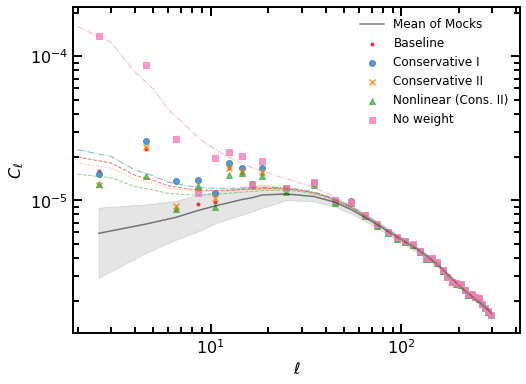

In [11]:
fnltag = 'zero'
cl_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_{fnltag}_desic_256_noweight_mean.npz')
cl_cov_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_{fnltag}_desic_256_noweight_cov.npz')

cl_err = np.diagonal(cl_cov_['clcov']*1000.)**0.5

mk = ['.', 'o', 'x', '^', 's', '1']
el_g = np.arange(300)

plt.figure(figsize=(8, 6))
ln, = plt.plot(cl_['el_bin'], cl_['cl'], label='Mean of Mocks', alpha=0.5)
plt.fill_between(cl_['el_bin'], cl_['cl']-cl_err, cl_['cl']+cl_err, alpha=0.1, color=ln.get_color())

for i, (n, nm) in enumerate(zip(['linp_all', 'linp_known', 'linp_known1', 'dnnp_known1', 'noweight'],
                 ['Baseline', 'Conservative I', 'Conservative II','Nonlinear (Cons. II)', 'No weight'])):
    cl_d = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_desic_256_{n}.npy', allow_pickle=True).item()
    cl_b = ut.histogram_cell(cl_d['cl_gg']['l'], cl_d['cl_gg']['cl'], bins=ut.ell_edges)[1]
    
    bestp = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_{n}_steps10k_walkers50.npz')
    fnl, b, noise = bestp['best_fit']
    print(nm, fnl, b)

    cl_bf = model(el_g, fnl=fnl, b=b, noise=noise) 
    ln = plt.plot(el_g[2:], cl_bf[2:], lw=1, alpha=0.6)
    plt.scatter(cl_['el_bin'], cl_b, label=nm, 
                marker=mk[i], color=ln[0].get_color(), alpha=0.8)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.ylim(1.2e-6, 2.2e-4)
plt.xlim(xmin=1.9)
plt.legend(ncol=1, loc='upper right')
plt.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/cl_obs.pdf', bbox_inches='tight')     

### fitting using all depth maps 

Text(0, 0.5, '$C_{\\ell}$')

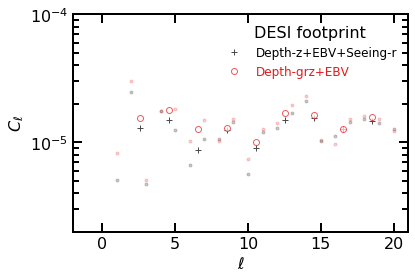

In [48]:
marker = ['+', 'o']
names = ['Depth-z+EBV+Seeing-r', 
        'Depth-grz+EBV']

for i, k in enumerate(['known1', 'known2']):
    cl = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_desic_256_dnnp_{k}.npy', allow_pickle=True).item()
    ln, = plt.plot(cl['cl_gg']['cl'], marker='.', ls='None', alpha=0.2)
    
    lb, clb = ut.histogram_cell(cl['cl_gg']['l'], cl['cl_gg']['cl'], bins=ut.ell_edges)
    plt.plot(lb, clb, color=ln.get_color(), marker=marker[i], mfc='w', ls='', label=names[i], alpha=0.7)
    
plt.ylim(2.0e-6, 1.0e-4)    
plt.xlim(-2, 21)
plt.yscale('log')
lgn = plt.legend(title='DESI footprint')
for i, a in enumerate(lgn.get_texts()):
    a.set_color('C%i'%i)
    
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

## LogCell vs Cell

Text(0.5, 0, 'Dist. of log[binned $C_{\\ell}]$')

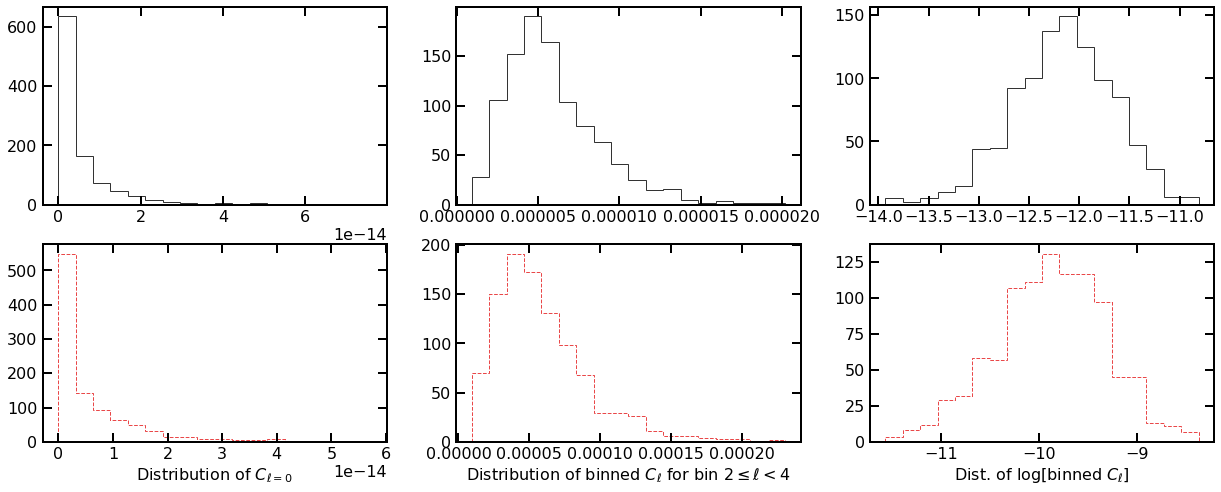

In [6]:
ls /fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_* -altr

-rw-rw-r--+ 1 medirz90 PHS0336 16001825 Oct 11 20:05 /fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_zero_desic_256_noweight_steps10k_walkers50.npz
-rw-rw-r--+ 1 medirz90 PHS0336 16001825 Oct 11 20:06 /fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_zero_sdecalsc_256_noweight_steps10k_walkers50.npz
-rw-rw-r--+ 1 medirz90 PHS0336 16001825 Oct 11 20:06 /fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_zero_ndecalsc_256_noweight_steps10k_walkers50.npz
-rw-rw-r--+ 1 medirz90 PHS0336 16001825 Oct 11 20:07 /fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_zero_bmzls_256_noweight_steps10k_walkers50.npz
-rw-rw-r--+ 1 medirz90 PHS0336 16001825 Oct 11 20:07 /fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_po100_desic_256_noweight_steps10k_walkers50.npz
-rw-rw-r--+ 1 medirz90 PHS0336 16001825 Oct 11 20:08 /fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_scaled_desic_256_noweight_steps10k_walkers50.npz
-rw-rw-r--+ 1 medirz90 PHS0336 16001825 Oct 13 10:50 /fs/ess/PHS0336/data/lognormal/v3/mcmc

In [7]:
def plot_mcmc_logmocks():
    stg = {'mult_bias_correction_order':0,'smooth_scale_2D':0.15, 
           'smooth_scale_1D':0.3, 'contours': [0.68, 0.95]}
    mc_kw = dict(names=['fnl', 'b', 'n0'], 
                 labels=['f_{NL}', 'b', '10^{7}n_{0}'], settings=stg) 
    read_kw = dict(ndim=3, iscale=[2])    
    po = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_logpo100_desic_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)    
    sc = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_logpozero_desic_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)    
    stats = {}  
    stats['100 [DESI]'] = po.stats    
    stats['100 [DESI] scaled cov'] = sc.stats        

    # Triangle plot
#     g = plots.get_single_plotter(width_inch=4*1.5)
#     g.settings.legend_fontsize = 14
#     g.plot_2d([po], 'fnl', 'b', filled=True)
#     g.add_x_marker(100)
#     g.add_y_marker(1.43)
#     g.get_axes().set_ylim(1.426, 1.434)
#     g.get_axes().set_xlim(100-2.2, 100+3.2)    
#     g.add_legend([r'$f_{\rm NL}=100$ [DESI]'], colored_text=True, legend_loc='lower left')    
#     g.fig.align_labels()

    
    g = plots.get_single_plotter(width_inch=4*1.5)
    g.settings.legend_fontsize = 14
    g.plot_2d([sc, po], 'fnl', 'b', filled=True)
    g.add_x_marker(100)
    g.add_y_marker(1.43)
#     g.get_axes().set_ylim(1.426, 1.434)
#     g.get_axes().set_xlim(100-2.2, 100+3.2)
    g.add_legend([r'w $f_{\rm NL}=0$ cov', 
                  r'$f_{\rm NL}=100$ [DESI]'], colored_text=True, legend_loc='lower left')    
    g.fig.align_labels()
#     g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_po100.pdf', bbox_inches='tight')    
    
#     g = plots.get_single_plotter(width_inch=4*1.5)
#     g.settings.legend_fontsize = 14
#     g.plot_2d([nd, sd, bm, ze], 'fnl', 'b', filled=True)
#     g.add_x_marker(0)
#     g.add_y_marker(1.43)
#     g.get_axes().set_ylim(1.426, 1.434)
#     g.get_axes().set_xlim(-2.2, 3.2)    
#     g.add_legend(['DECaLS North', 'DECaLS South', 'BASS+MzLS', r'$f_{\rm NL}=0$ [DESI]'], 
#                  colored_text=True, legend_loc='lower left')    
#     g.fig.align_labels()
#     g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_zero.pdf', bbox_inches='tight')    

    #pstats = pd.DataFrame(stats,
    #                  index=['MAP [scipy]', 'Mean [chain]', '16th', '84th', '2.5', '97.5']).T  
    for s, v in stats.items():
        print(f"{s:20s} & ${v[0]:6.2f}$ & ${v[1]:6.2f}$ & ${v[2]:6.2f} < \ fnl < {v[3]:6.2f}$ & ${v[4]:6.2f} < \ fnl < {v[5]:6.2f}$ ")    
    return stats            

Removed no burn in
Removed no burn in
100 [DESI]           & $100.97$ & $100.97$ & $100.33 < \ fnl < 101.61$ & $ 99.72 < \ fnl < 102.23$ 
100 [DESI] scaled cov & $101.01$ & $101.03$ & $100.42 < \ fnl < 101.63$ & $ 99.85 < \ fnl < 102.21$ 


{'100 [DESI]': [100.96545973398948,
  100.96797949483434,
  100.32645339066521,
  101.61218246744221,
  99.71911482524897,
  102.23073356156571],
 '100 [DESI] scaled cov': [101.01052453667843,
  101.02886583641937,
  100.42197601929661,
  101.62748672493447,
  99.85020414017401,
  102.21274253039188]}

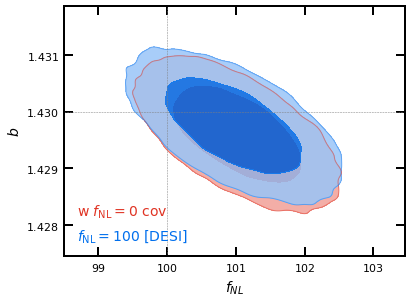

In [8]:
plot_mcmc_logmocks()

In [8]:
region = 'desic'
data_path = '/fs/ess/PHS0336/data/'    
dt = ft.read(f'{data_path}/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{region}_256.fits')
weight_ = ut.make_hp(256, dt['hpix'], dt['fracgood'])
weight  = hp.ud_grade(weight_, 1024)

In [9]:
def read_inputs(path_cl, path_cov, scale=True):
    
    dcl_obs = np.load(path_cl)
    dclcov_obs = np.load(path_cov)
    assert np.array_equal(dcl_obs['el_edges'], dclcov_obs['el_edges'])
    
    el_edges = dcl_obs['el_edges']
    cl_obs = dcl_obs['cl']
    clcov = dclcov_obs['clcov']
    if scale:
        clcov *= 1000.
    
    invcov_obs = np.linalg.inv(clcov)
    return el_edges, cl_obs, invcov_obs

In [13]:
__, cl_obst, icov_obst = read_inputs('/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_po100_desic_256_noweight_mean.npz', 
                                     '/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_po100_desic_256_noweight_cov.npz', True)

In [14]:
el_edges, cl_obs, icov_obs = read_inputs('/fs/ess/PHS0336/data/lognormal/v3/clustering/logclmock_0_lrg_po100_desic_256_noweight_mean.npz', 
                                        '/fs/ess/PHS0336/data/lognormal/v3/clustering/logclmock_0_lrg_po100_desic_256_noweight_cov.npz', True)

In [12]:
z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.0)
model.add_kernels(model.el_model)
model.add_window(weight, weight > 0, np.arange(2048), ngauss=2048)  

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

In [15]:
from scipy.optimize import minimize
from lssutils.extrn.mcmc import LogPosterior, Posterior

In [33]:
lg = LogPosterior(model, cl_obs, icov_obs, el_edges)
def logpost(params):
    return lg.logpost(params)
def neglogpost(params):
    return -lg.logpost(params)
    #val = val_ if np.isfinite(val_) else np.inf
    #return val

NEw II+


In [34]:
res = minimize(neglogpost, [0.0, 1.4, 1.0e-6], method='Powell')

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/scipy/optimize/optimize.py:2150: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [38]:
res

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.10659670e+02,  8.73522440e-02, -1.98511523e-07],
       [ 7.63122586e-01,  1.76672300e-03, -3.60182184e-09]])
     fun: 0.01943796807165185
 message: 'Optimization terminated successfully.'
    nfev: 546
     nit: 8
  status: 0
 success: True
       x: array([1.00551778e+02, 1.43340881e+00, 5.24944477e-07])

In [23]:
lg = Posterior(model, cl_obst, icov_obst, el_edges)
def logpost2(params):
    return lg.logpost(params)
def neglogpost2(params):
    val_ = -lg.logpost(params)
    val = val_ if np.isfinite(val_) else np.inf
    return val

In [24]:
res2 = minimize(neglogpost2, [0.0, 1.4, 1.0e-6], method='Powell')

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/scipy/optimize/optimize.py:2150: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [25]:
res2

   direc: array([[-4.33844322e+01,  9.29837193e-02, -1.98376544e-07],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-4.64025464e-01,  1.10003502e-04, -1.52736764e-10]])
     fun: 0.019485064392157424
 message: 'Optimization terminated successfully.'
    nfev: 346
     nit: 7
  status: 0
 success: True
       x: array([1.00553751e+02, 1.43340823e+00, 5.24935896e-07])

In [36]:
np.random.seed(85)
for p in res.x *(1.+0.1*np.random.randn(50, 3)):
    print(p, neglogpost(p))

[1.02330044e+02 1.77423818e+00 5.77372407e-07] 1291.2908701030494
[8.73779789e+01 1.45923739e+00 4.32304689e-07] 3.2322622253122493
[8.60408909e+01 1.23283398e+00 5.68008507e-07] 456.7063412533222
[1.13576243e+02 1.56846421e+00 5.12769320e-07] 205.00308912803283
[9.42029593e+01 1.34135859e+00 5.04908837e-07] 125.68488850437805
[8.28200351e+01 1.66442675e+00 4.78848662e-07] 489.79493946117066
[9.55384971e+01 1.56345387e+00 5.27114042e-07] 188.1220994999242
[1.18806699e+02 1.27141341e+00 5.00148882e-07] 360.8837019337945
[9.55494188e+01 1.43899004e+00 5.97187059e-07] 10.912861517386744
[1.05493218e+02 1.51753713e+00 4.57535499e-07] 49.55904657912657
[1.18449093e+02 1.24864265e+00 4.83802327e-07] 504.6168673173987
[8.99039725e+01 1.37503484e+00 5.12224823e-07] 52.138889759805245
[1.11684100e+02 1.44385844e+00 4.50795713e-07] 4.095632810052974
[9.64768169e+01 1.21924510e+00 5.76382243e-07] 500.22365477869914
[1.04692905e+02 1.54170321e+00 5.33584490e-07] 142.37312415175495
[1.01274827e+02 

In [37]:
neglogpost(res.x)

0.01943796807165185

In [75]:
neglogpost([100, 1.423, 5.2e-7])

1.798865434220585

In [76]:
res.x

array([1.00551778e+02, 1.43340881e+00, 5.24944477e-07])

In [77]:
el_g = np.arange(310)
lb, __ = ut.histogram_cell(el_g, np.ones(el_g.size), bins=ut.ell_edges)

/tmp/slurmtmp.20987856/ipykernel_18842/2498212536.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(el_g, np.log10(model(el_g, *res.x)))


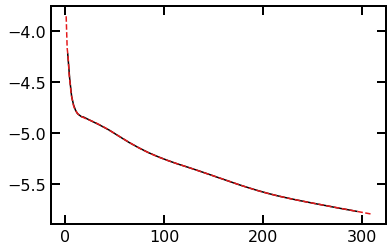

In [78]:
plt.plot(lb, cl_obs)
plt.plot(el_g, np.log10(model(el_g, *res.x)))

In [33]:
cl_obs, icov_obs

(array([-4.22630485, -4.46734291, -4.64351073, -4.72885742, -4.78014649,
        -4.81291651, -4.82787708, -4.84244498, -4.84536596, -4.87597449,
        -4.92301937, -4.9744623 , -5.03534458, -5.09491211, -5.14808942,
        -5.19635031, -5.23750034, -5.27480159, -5.30857641, -5.3393187 ,
        -5.37157052, -5.40465155, -5.43857663, -5.47169347, -5.50547233,
        -5.53653171, -5.56625927, -5.59317497, -5.61806668, -5.63968508,
        -5.66018915, -5.67933478, -5.69828229, -5.7162333 , -5.73531497,
        -5.75270692, -5.77109353]),
 array([[ 1.97569961e+01, -1.00552062e+01, -1.38600250e+00, ...,
         -9.43402686e+00, -1.56511349e-01, -5.27716215e+00],
        [-1.00552062e+01,  4.12227757e+01, -1.09134641e+01, ...,
          4.92029367e+00,  7.79461302e+00,  1.87115569e+01],
        [-1.38600250e+00, -1.09134641e+01,  6.40695006e+01, ...,
         -8.75495029e+00, -4.05097350e+01,  6.01799193e+01],
        ...,
        [-9.43402686e+00,  4.92029367e+00, -8.75495029e+00, ..

In [31]:
#for fnl in np.linspace(-90, 90, 11):
for b in np.linspace(1.3, 1.5, 11):
    print(b, neglogpost([100, b, 5.2e-7]))

1.3 2682837.2757601384
1.32 2665656.0058146035
1.34 2648677.3540284103
1.36 2631898.770716059
1.3800000000000001 2615317.6738969125
1.4 2598931.4569200035
1.42 2582737.495402479
1.44 2566733.15344341
1.46 2550915.7892813156
1.48 2535282.7602967345
1.5 2519831.4276141915


In [15]:
po = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_logpo100_desic_256_noweight_steps10k_walkers50.npz')

Removed no burn in


In [16]:
params = po.samples.mean(axis=0)
params

array([94.87484261,  1.43101064,  5.25477646])

/tmp/slurmtmp.20964564/ipykernel_11475/337805774.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(el_g, np.log(model(el_g, params[0], params[1], params[2]*1.0e-7)), label='Model fNL=%.1f'%params[0])
/tmp/slurmtmp.20964564/ipykernel_11475/337805774.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(el_g, np.log(model(el_g, 100, params[1], params[2]*1.0e-7)), label='Model fNL=100')


(-11.5, -8.5)

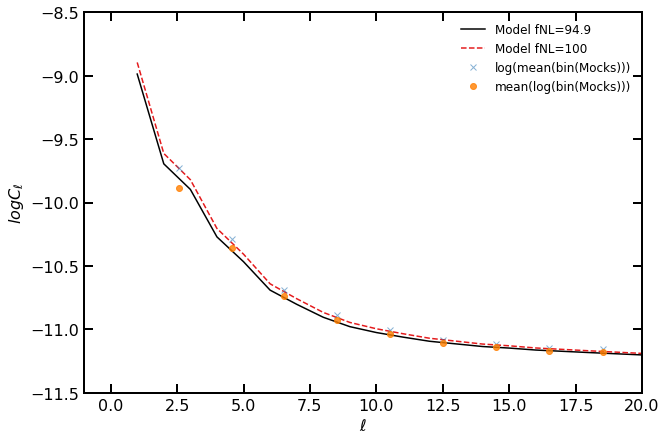

In [21]:

plt.figure(figsize=(10, 7))
plt.plot(el_g, np.log(model(el_g, params[0], params[1], params[2]*1.0e-7)), label='Model fNL=%.1f'%params[0])
plt.plot(el_g, np.log(model(el_g, 100, params[1], params[2]*1.0e-7)), label='Model fNL=100')

plt.plot(lb, np.log(cl_obst),  marker='x', ls='none', alpha=0.6, label='log(mean(bin(Mocks)))')
plt.plot(lb, cl_obs, marker='o', ls='none', alpha=0.8, label='mean(log(bin(Mocks)))')#, marker='s', ls='none', capsize=3, alpha=0.3, label='fNL=100 Mocks')

# plt.errorbar(lb, cl_obs, yerr=np.diagonal(cov_obs)**0.5, marker='s', ls='none', capsize=3, alpha=0.3, label='fNL=100 Mocks')
# plt.errorbar(lb*1.01, cl_obs, yerr=np.diagonal(cov_obs2)**0.5, marker='', ls='none', capsize=3, zorder=-10)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$logC_{\ell}$')

plt.legend()
# plt.xscale('log')
plt.xlim(-1, 20)
plt.ylim(-11.5, -8.5)
# plt.yscale('log')

In [6]:
d = np.load('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_logpo100_desic_256_noweight_steps10k_walkers50.npz')

In [7]:
d.files

['chain',
 'log_prob',
 'best_fit',
 'best_fit_logprob',
 'best_fit_success',
 '#data',
 '#params']

In [8]:
logp = -2.0*d['log_prob'][5000:]

In [9]:
fnl = d['chain'][5000:, :, 0]

Text(0, 0.5, '$\\chi^{2}$')

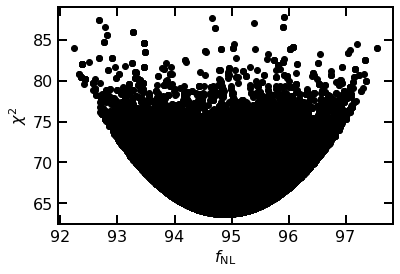

In [10]:
plt.scatter(fnl.flatten(), logp.flatten())
plt.xlabel(r'$f_{\rm NL}$')
plt.ylabel(r'$\chi^{2}$')

In [11]:
logp.shape

(5000, 50)

## Extreme Window

In [38]:
d_1 = hp.read_map('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desi_known1.hp256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [31]:
mask = d_1 != hp.UNSEEN
np.percentile(d_1[mask], [2, 98]) 

array([40.12145233, 45.35710144])

In [32]:
is_ex = ((d_1 < 40.12) | (d_1 > 45.36)) & mask

In [33]:
is_ex.sum()/mask.sum(), mask.sum(), mask.mean()

(0.03983606918863069, 317451, 0.4036598205566406)

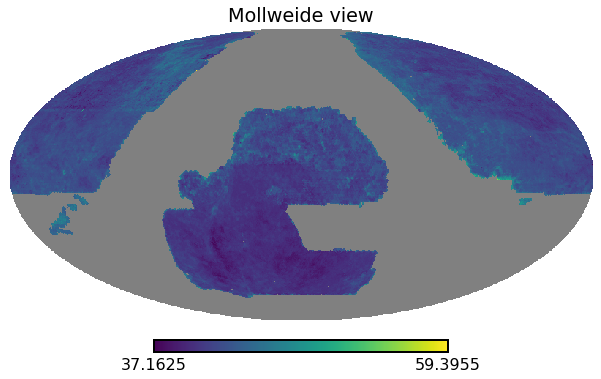

In [39]:
hp.mollview(d_1)

In [35]:
ix_ex = np.argwhere(is_ex).flatten()

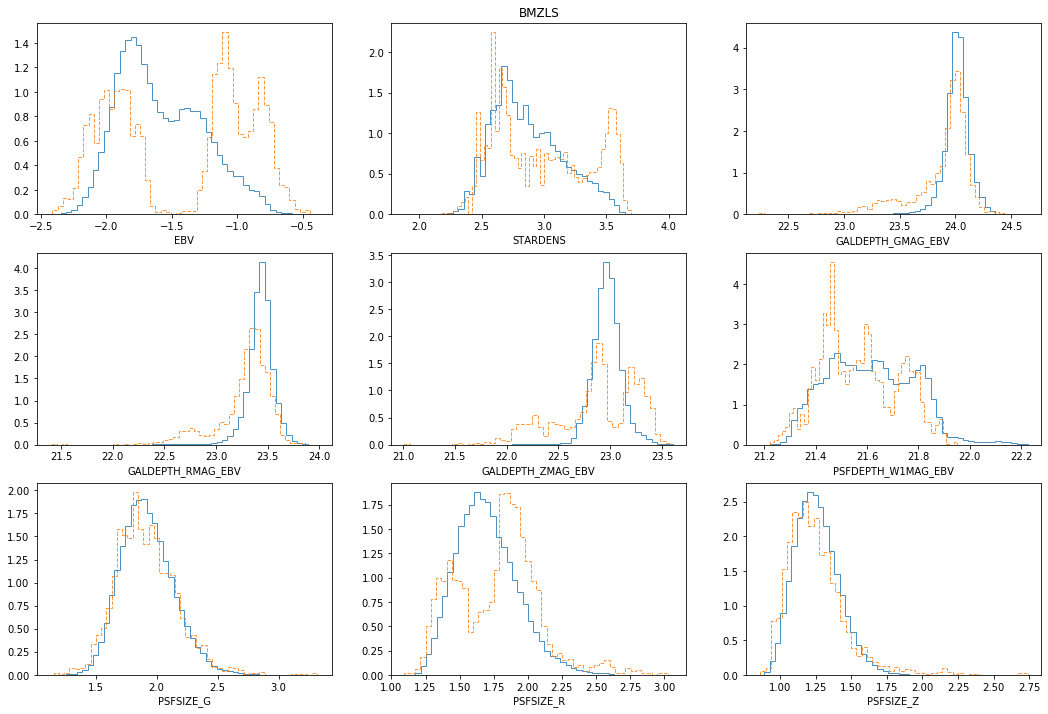

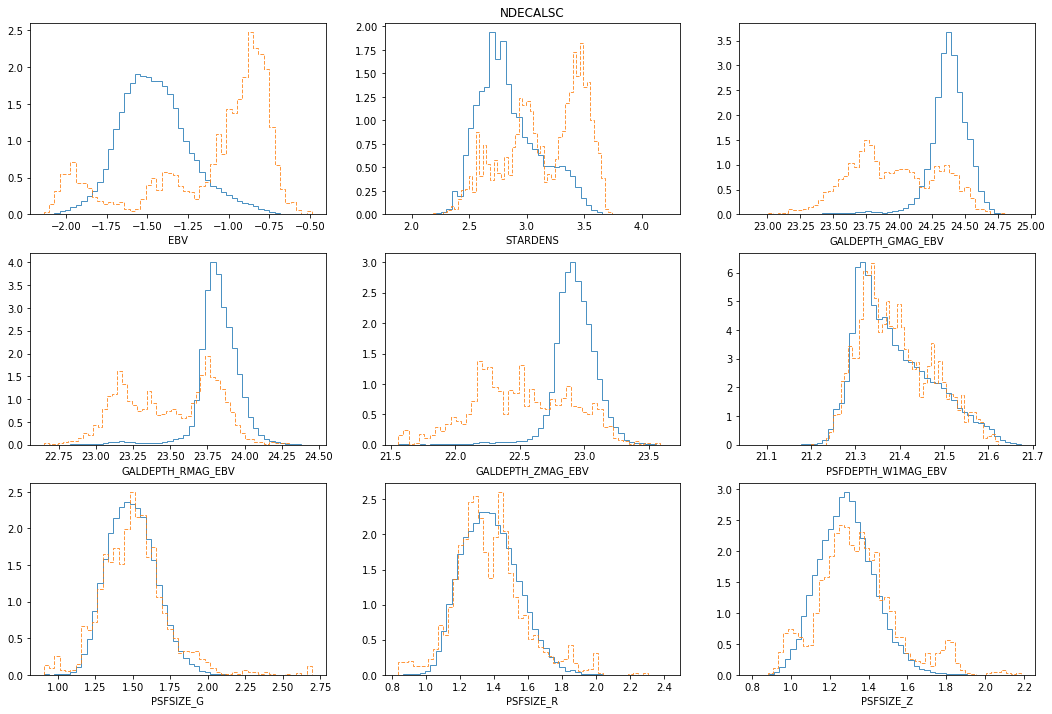

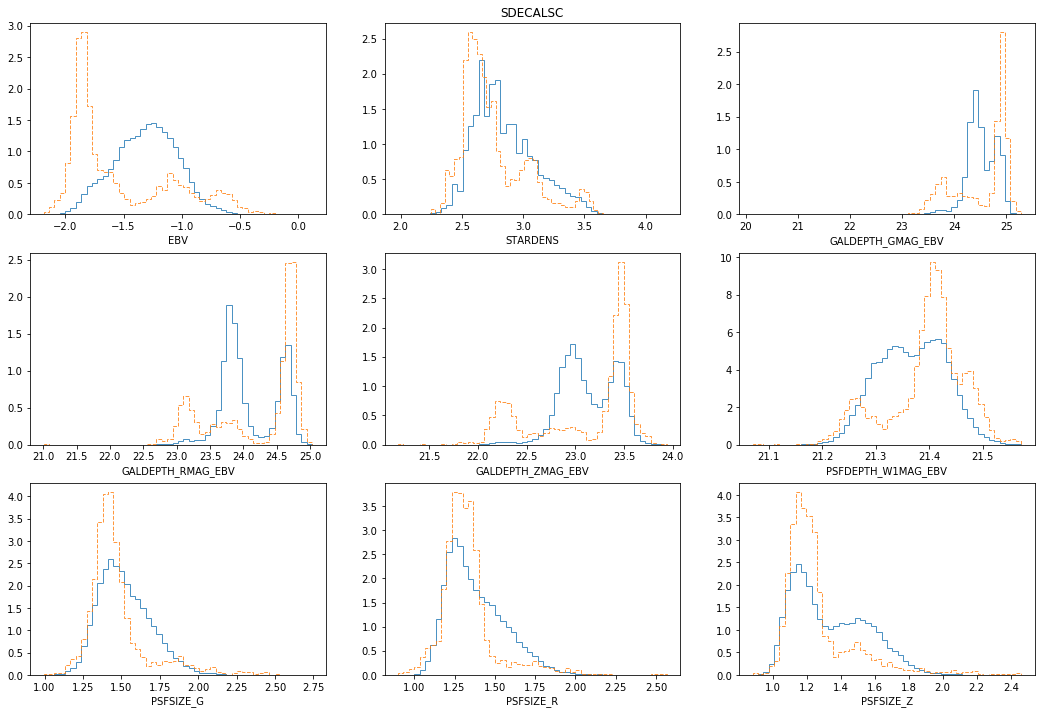

In [37]:
for r in ['bmzls', 'ndecalsc', 'sdecalsc']:
    
    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits')
    is_comm = np.in1d(data['hpix'], ix_ex)
    #is_comm.sum(), ix_ex.size
    kw = dict(density=True, bins=50, histtype='step', alpha=0.8)

    fg, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
    ax = ax.flatten()

    for i in range(data['features'].shape[1]):
        if i< 2:
            ax[i].hist(np.log10(data['features'][:, i]), ls='-', **kw)
            ax[i].hist(np.log10(data['features'][is_comm, i]), ls='--', **kw)
        else:
            ax[i].hist(data['features'][:, i], ls='-', **kw)
            ax[i].hist(data['features'][is_comm, i], ls='--', **kw)

        ax[i].set_xlabel(ut.maps_dr9[i])     
        

    ax[1].set_title(r.upper())
    plt.show()

Removed no burn in
Removed no burn in
Removed no burn in


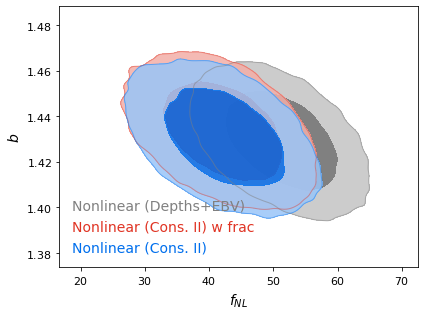

,MAP [scipy],MAP [chain],Mean [chain],Median [chain],16th,84th
Nonlinear (Depths+EBV),51.662924,51.553357,51.246052,51.351139,45.627949,56.829878
Nonlinear (Cons. II) w frac,42.608974,42.694712,42.121080,42.289579,36.120379,48.114209
Nonlinear (Cons. II),42.845528,42.682128,42.255626,42.360824,36.203137,48.370399


In [20]:
stg = {'mult_bias_correction_order':0,'smooth_scale_2D':0.15, 
       'smooth_scale_1D':0.3, 'contours': [0.68, 0.95]}
mc_kw = dict(names=['fnl', 'b', 'n0'], 
             labels=['f_{NL}', 'b', '10^{7}n_{0}'], settings=stg) 
read_kw = dict(ndim=3, iscale=[2])

knn1 = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desi_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
knn1f = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desi_dnnp_known1frac_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)       
knn2 = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desi_dnnp_known2_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
stats = {}
stats['Nonlinear (Depths+EBV)'] = knn2.stats   
stats['Nonlinear (Cons. II) w frac'] = knn1f.stats    
stats['Nonlinear (Cons. II)'] = knn1.stats



lgnd_labels = stats.keys()

# Triangle plot
g = plots.get_single_plotter(width_inch=4*1.5)
g.settings.legend_fontsize = 14
g.plot_2d([knn2, knn1f, knn1], 'fnl', 'b', filled=True, legend_labels=lgnd_labels)
g.add_legend(lgnd_labels, colored_text=True, legend_loc='lower left', )    
g.fig.align_labels()
g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_dr9_frac.pdf', bbox_inches='tight')    
plt.show()

pstats = pd.DataFrame(stats,
                  index=['MAP [scipy]', 'MAP [chain]', 'Mean [chain]',
                         'Median [chain]', '16th', '84th']).T 
pstats

In [13]:
zbdndz = init_sample(kind='lrg')

# read survey geometry
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecals_256.fits')
w = np.zeros(12*256*256)
w[dt['hpix']] = dt['fracgood']
weight = hp.ud_grade(w, 1024)
mask = weight > 0.5

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.0)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

In [12]:
ls /fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals*

/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecalsc_dnnp_known1_steps10k_walkers50.npz
/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals_dnnp_known1_steps10k_walkers50.npz


No weight 47.06827841846321 1.392588755439644


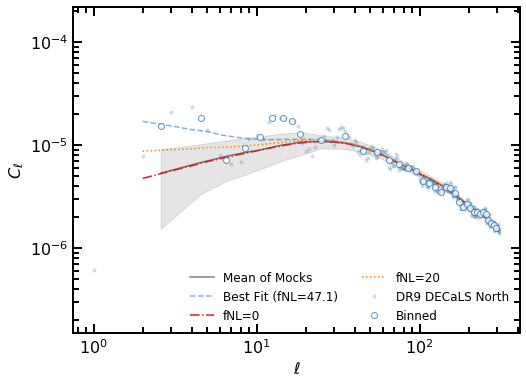

In [14]:
cl_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_ndecals_256_noweight_mean.npz')
cl_cov_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_ndecals_256_noweight_cov.npz')

cl_err = np.diagonal(cl_cov_['clcov']*1000.)**0.5

el_g = np.arange(300)
plt.figure(figsize=(8, 6))
ln, = plt.plot(cl_['el_bin'], cl_['cl'], label='Mean of Mocks', alpha=0.5)
plt.fill_between(cl_['el_bin'], cl_['cl']-cl_err, cl_['cl']+cl_err, alpha=0.1, color=ln.get_color())

n = 'dnnp_known1'
cl_d = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_ndecals_256_{n}.npy', allow_pickle=True).item()
cl_b = ut.histogram_cell(cl_d['cl_gg']['l'], cl_d['cl_gg']['cl'], bins=ut.ell_edges)[1]

bestp = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals_{n}_steps10k_walkers50.npz')
fnl, b, noise = bestp['best_fit']
print(nm, fnl, b)

plt.plot(el_g[2:], model(el_g, fnl=fnl, b=b, noise=noise)[2:], alpha=0.6, label=f'Best Fit (fNL={fnl:.1f})', color='C2')
plt.plot(el_g[2:], model(el_g, fnl=0.0, b=b+0.03, noise=noise)[2:], label='fNL=0', color='C1')
plt.plot(el_g[2:], model(el_g, fnl=20.0, b=b+0.03, noise=noise)[2:], label='fNL=20', color='C3')

plt.plot(cl_d['cl_gg']['cl'][:310], label='DR9 DECaLS North', marker='.', ls='none', alpha=0.2, color='C2')
plt.plot(cl_['el_bin'], cl_b, alpha=0.8,  color='C2', label='Binned', ls='none', marker='o', mfc='w')


    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.ylim(1.5e-7, 2.2e-4)

plt.legend(ncol=2, loc=4)
# plt.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/cl_obs.pdf', bbox_inches='tight')     

In [11]:
dt = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
hpix = dt['hpix']

In [ ]:
ix = '96'

m0c = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-{ix}-f1z1-contaminated.fits')
m100c = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-po100-{ix}-f1z1-contaminated.fits')
m0 = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-{ix}-f1z1.fits')
m100 = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-po100-{ix}-f1z1.fits')



[Text(0, 0.5, 'Ncont/Nfid'), Text(0.5, 0, 'HPIX')]

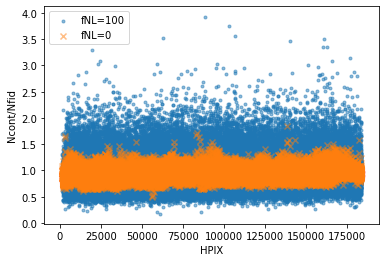

In [31]:

#plt.scatter(m0[hpix], (m0c-m0)[hpix], alpha=0.5)
#plt.scatter(m100[hpix], (m100c-m100)[hpix], alpha=0.5, zorder=-12)
#plt.scatter(m0[hpix], m100[hpix], marker='.', alpha=0.2)

fg, ax = plt.subplots(nrows=1, figsize=(6, 4), sharex=True)

ax.scatter(hpix, m100c[hpix]/m100[hpix], marker='.', alpha=0.5)
ax.scatter(hpix, m0c[hpix]/m0[hpix], marker='x', alpha=0.5)
ax.legend(['fNL=100', 'fNL=0'])
ax.set(xlabel='HPIX', ylabel='Ncont/Nfid')

# ax[1].scatter(hpix, m100c[hpix]-m100[hpix], marker='.', alpha=0.5)
# ax[1].scatter(hpix, m0c[hpix]-m0[hpix], marker='x', alpha=0.5)
# ax[1].legend(['fNL=100', 'fNL=0'])
# ax[1].set(xlabel='HPIX', ylabel='Ncont-Nfid')

In [3]:
from sympy.physics.wigner import wigner_3j
from scipy.optimize import curve_fit

In [4]:
data = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desi_256.fits')
weight = ut.make_hp(256, data['hpix'], data['fracgood'])

0.4856058756510417


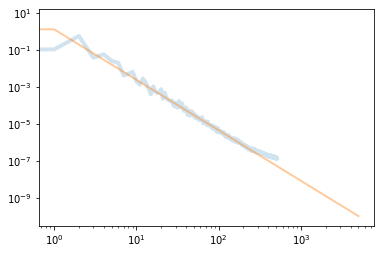

In [58]:
def model(l, *p):
    return p[0]*np.log10(l)+p[1]

def get_cl_wind(weight, mask, plot=False, nside=256):

    fsky = mask.mean()
    print(fsky)
    weight[~mask] = hp.UNSEEN
    cl_wind = hp.anafast(weight, lmax=2*nside) / fsky

    el_p = 1
    el = np.arange(5000)
    is_small = el < el_p

    lmin = 10
    lmax = 200 #2*nside-1
    x = np.arange(lmin, lmax+1)
    y = cl_wind[lmin:lmax+1]
    res = curve_fit(model, x, np.log10(y), p0=[1, 1])

    cl_window = np.zeros(el.size)
    cl_window[:el_p] = cl_wind[:el_p]
    cl_window[~is_small] = 10**model(el[~is_small], *res[0])
    
    if plot:
        x_g = np.arange(el_p, 5000)
        plt.plot(cl_wind, alpha=0.2, lw=4)
        plt.plot(cl_window, alpha=0.4, lw=2, ls='-')
        #plt.plot(x_g, 10**model(x_g, *res[0]), lw=1)
        plt.xscale('log')
        plt.yscale('log')    
        
    return cl_window

mask = weight > 0
cl_w = get_cl_wind(weight, mask, plot=True)

In [59]:
!qstat -u medirz90


o0018.ten.osc.edu:
                                                                               Req'd  Req'd   Elap 
Job id               Username Queue    Name                 SessID NDS   TSK   Memory Time Use S Time 
-------------------- -------- -------- -------------------- ------ ----- ----- ------ ----- - -----
20609558             medirz90 serial   ondemand/sys/dashboa --         1     2     -- 01:00 R 00:59


In [60]:
l1 = np.array([2, 5, 10, 30])
l2 = np.arange(51)
l3 = np.arange(2000)

mixm = np.zeros((l1.size, l2.size))
for i, l1_ in enumerate(l1):
    print('.', end='')
    
    for l2_ in l2:
        l3sum_ = 0.0        
        for l3_ in l3:
            wj = float(wigner_3j(l1_, l2_, l3_, 0, 0, 0))
            l3sum_ += (2.*l3_+1.)*cl_w[l3_]*wj*wj        
        mixm[i, l2_] = l3sum_*(2.*l2_+1.)/(4.*np.pi)

....

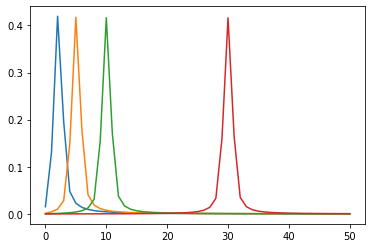

In [61]:
plt.plot(mixm[0, :])
plt.plot(mixm[1, :])
plt.plot(mixm[2, :])
plt.plot(mixm[3, :])
# plt.yscale('log')

22.7  9  2.5
19.6  9  2.2
22.1  9  2.5


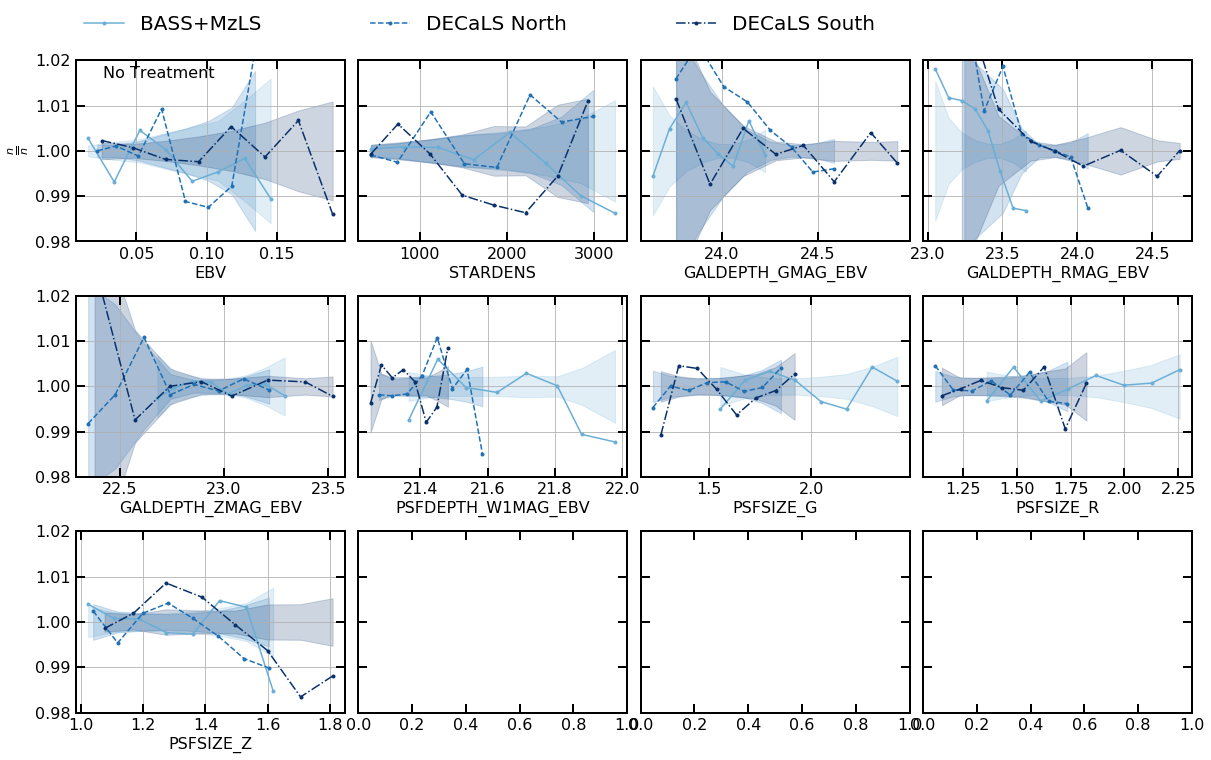

In [19]:
dv.plot_nnbar(['/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_bmzls_256_dnnp_known1.npy',
               '/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_ndecalsc_256_dnnp_known1.npy',
               '/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_sdecalsc_256_dnnp_known1.npy'],
            title='No Treatment', axes=np.arange(9), 
            lb=['BASS+MzLS', 'DECaLS North', 'DECaLS South'], 
            ylim=(0.98, 1.02))#, delaxes=[15, 14, 13])

In [ ]:
## combining Obiwon with NN
d = md.ft.read('/fs/ess/PHS0336/data/rongpu/subset_dr9_lrg_sv3_v2.fits')

In [ ]:
for n in d.dtype.names:
    print(n)

In [ ]:
mask_clean = md.np.ones(len(d), dtype=bool)
for bit in [1, 12, 13]:
    mask_clean &= (d['maskbits'] & 2**bit)==0

In [ ]:
dt = md.ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecals_256.fits')

In [ ]:
md.np.unique(d['maskbits'])

In [ ]:
dm = d[mask_clean]
d.size, dm.size

In [ ]:
dhp = hpixsum(256, d['ra'], d['dec'])
dhpw = hpixsum(256, d['ra'], d['dec'], weights=d['obiwan_weight'])

In [ ]:
dhp_my = md.make_hp(256, dt['hpix'], dt['label'])

In [ ]:
md.hp.mollview(dhp, rot=120, min=0, max=97, title="Hui's LRGs")

In [ ]:
md.hp.mollview(dhp_my, rot=120, min=0, max=97, title="Rongpu's LRGs")

In [ ]:
def run_rfe(filename):
 
    maps_dr9 = ['ebv', 'nstar']\
                + [f'galdepth_{b}' for b in ['r', 'g', 'z']]\
                + [f'psfdepth_{b}' for b in ['r', 'g', 'z', 'w1', 'w2']] \
                + [f'psfsize_{b}' for b in ['r', 'g', 'z']]

    dl = src.MyDataLoader(filename, 
                          do_kfold=True, seed=85)
    axes = []
    for i in range(5):
        fs = src.FeatureElimination(model, dl.load_data(-1, i))
        fs.run([j for j in range(13)])
        axes.append(fs.results['axes_to_keep'])


    #     fs.plot(labels=maps_dr9, cmap='seismic', vmin=0.99, vmax=1.01)
    
    weights = [[(1.+i)/len(axes_i) for i in range(len(axes_i))] for axes_i in axes]

    axes_ = []
    for axi in axes:
        for axj in axi:
            axes_.append(axj)

    weights_ = []
    for wt in weights:
        for wj in wt:
            weights_.append(wj)

    plt.hist(axes_, weights=weights_, bins=np.arange(13), align='left', width=0.8)
    plt.xticks(ticks=np.arange(13), labels=maps_dr9, rotation=90)
    plt.xlim(-1, 13)
    plt.ylim(0, 5.2)

In [ ]:
run_rfe('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')

In [ ]:
run_rfe('/fs/ess/PHS0336/data/lognormal/v0/tables/bmzls/nlrg-10-bmzls.fits')

## Fisher

In [ ]:
region = 'bmzls'
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'  

el_edges, cl_obs, invcov_obs = read_inputs(path_cl, path_cov)
cov_obs = np.linalg.inv(invcov_obs)
weight, mask = read_mask(region)

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

In [ ]:
cl_ = np.load(path_cl)
el_bin = cl_['el_bin']
el_edges = cl_['el_edges']
cl_cov = np.load(path_cov)
cov = cl_cov['clcov']
cl_cov.files

In [ ]:
noise = 5.24256916e-07
fnl = 0.0
eps = 1.0e-8
el_ = np.arange(el_edges.max()+1)


mp_ = model(el_, fnl+eps, noise=noise)
mn_ = model(el_, fnl-eps, noise=noise)
el_b, mp = histogram_cell(el_, mp_, bins=el_edges)
mn = histogram_cell(el_, mn_, bins=el_edges)[1]
assert np.array_equal(el_b, el_bin)

dcl_f = (mp-mn)/(2*eps)

mp_ = model(el_, fnl=fnl, noise=noise+eps)
mn_ = model(el_, fnl=fnl, noise=noise-eps)
el_b, mp = histogram_cell(el_, mp_, bins=el_edges)
mn = histogram_cell(el_, mn_, bins=el_edges)[1]

dcl_n = (mp-mn)/(2*eps)

In [ ]:
dcl_l = [dcl_f, dcl_n]

icov = np.linalg.inv(cov)
fisher = np.zeros((2, 2))
for i, dcl_i in enumerate(dcl_l):
    for j, dcl_j in enumerate(dcl_l):
        fisher[i, j] = dcl_i.dot(icov.dot(dcl_j))
fisher

In [ ]:
ifisher = np.linalg.inv(fisher)
ifisher

In [ ]:
pdf = lambda x, mu, sig:np.exp(-0.5*(x-mu)**2/sig**2)/np.sqrt(2.*np.pi*sig**2)

In [ ]:
from scipy.stats import norm

In [ ]:
sig = np.sqrt(ifisher[0, 0])
print(sig)
fnl_g = np.linspace(-200, 200, 200)
plt.plot(fnl_g, pdf(fnl_g, 0.0, sig))

In [ ]:
nmocks = 1000
nbins = 17
hf_b = (nmocks - 1.0)/(nmocks - nbins - 2.0)

fisher = []
for i, lmin in enumerate(el_bin[:7]):
    print(i, lmin)

    hf_a = (nmocks - 1.0)/(nmocks - (nbins-i) - 2.0)
    
    cov_i = cov[i:, i:]/(hf_b)*hf_a
    
    icov_i = np.linalg.inv(cov_i)
    
    fisher.append((lmin, dcl_f[i:].dot(icov_i.dot(dcl_f[i:]))))
    
fisher = np.array(fisher)
plt.plot(fisher[:, 0], fisher[:, 1])

In [ ]:
noise = 5.24256916e-07
el_ = np.arange(0, 100).astype('int')
fnl = 0.0
for eps in [1.0e-8, ]:
    print(fnl+eps, fnl-eps)
    m_p = model(el_, fnl=fnl+eps, noise=noise)
    m_n = model(el_, fnl=fnl-eps, noise=noise)
    plt.plot(el_, 1.0e8*(m_p-m_n)/(2*eps)), #label='eps = %3.e'%eps)
    
plt.xlabel(r'$\ell$')
plt.yscale('log')
plt.title(r'$10^{8}~\partial C_{\ell} / \partial f_{\rm NL}$')
# plt.legend(loc='upper right', fontsize=15)
# plt.savefig('dClfnl.png', dpi=300, bbox_inches='tight')

In [ ]:
fisher2 = []
for i, lmax in enumerate(el_bin[-3:]):
    ix = -3+i
    print(i, ix, lmax)
    cov_i = cov[:ix, :ix]*()*()
    icov_i = np.linalg.inv(cov_i)
    fisher2.append((lmax, dcl[:ix].dot(icov_i.dot(dcl[:ix]))))
    
fisher2 = np.array(fisher2)

In [ ]:
plt.plot(fisher[:, 0], fisher[:, 1], marker='o', mfc='w')
plt.xlabel(r'$\ell_{\rm min}$')
plt.ylabel(r'F$_{11}$')
plt.xlim(0., 70.)

In [ ]:
plt.plot(fisher2[:, 0], fisher2[:, 1], marker='o', mfc='w')
plt.xlabel(r'$\ell_{\rm max}$')
plt.ylabel(r'F$_{11}$')
# plt.xlim(0., 70.)